# Reinforcement Learning for Dynamic Product Sorting
### Deep Q-Learning Implementation

In [35]:
#imports
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import itertools
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Manually set device to cpu
device = torch.device("cpu") #TODO: Fix tensors to be on GPU

### Enviroment Functions

In [36]:
def initialState():
    state = list(np.random.randint(0,3) for x in range(3))
    state.extend([0, 0]) # add empty pallet
    return torch.tensor([state], device=device, dtype=torch.float)

def newProduct():
    return np.random.randint(1,3)

def reward(topItem, bottomItem):
    return bottomItem - topItem

#def chooseAction(state):
#    pass

def getPossibleActions(state, numberOfActions):
    state = state.numpy().flatten()
    possibleActions = np.array([0 for i in range(numberOfActions)])
    if state[0] != 0: # if belt is not empty
        for i in range(2): #range(buffer_size)
            if state[1+i] == 0: # belt_size+i # if buffer spot empty 
                possibleActions[i] = 1 # belt to pallet
        possibleActions[2] = 1 # [buffer_size] # move belt product to pallet 
    for i in range(2): #range(buffer_size)
        if state[1+i] != 0: # belt_size+i # if product in buffer spot
            possibleActions[2 + 1 + i] = 1 # [buffer_size+1+i] # move buffer product to pallet
    possibleActions[-1] = 1 #wait
    return possibleActions


def getNextState(state, action):
    done = False
    state = state.numpy().flatten()
    action = action.numpy().flatten()[0]
    pallet = [state[3], state[4]]
    if action in range(2): # range(buffer_size) # move belt to buffer
        prod = state[0] # belt product
        state[0] = newProduct() # new belt product
        state[1+action] = prod # move product to buffer spot
    elif action in range(2,3): # range(buffer_size to buffer_size + belt_size) # move belt to pallet
        prod = state[0] # belt product
        for i in range(-2,0): #range(pallet capacity)
            if state[i] == 0:
                state[0] = newProduct() # new belt product
                state[i] = prod # move product to pallet
                break
            else:
                if state[-1] != 0:
                    raise('Tried to place belt item in pallet, but pallet is full')
    elif action in range(3,5): # range(buffer_size + belt_size to 2*buffer_size + belt_size) # move buffer to pallet
        prod = state[action-2] # range(action - buffer_cap) # buffer product
        for i in range(-2,0): #range(pallet capacity)
            if state[i] == 0:
                state[action-2] = 0 # remove buffer product
                state[i] = prod # place buffer product on belt
                break
            else:
                if state[-1] != 0:
                    raise('Tried to place buffer item in pallet, but pallet is full')
    else: #wait
        if state[0] == 0: # if belt is empty
            state[0] = newProduct()
    reward = -0.1 # minus 0.1 for every action taken
    if state[-1] != 0: # if pallet full
        reward += state[-2] - state[-1] # reward added to initial
        # empty full pallet
        state[-1] = 0
        state[-2] = 0
        done = True
    return torch.tensor([list(state)], device=device, dtype=torch.float), reward, done

### Replay Memory

In [37]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Network

In [38]:
class Net(nn.Module):
    def __init__(self,num_state,num_action):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(num_state, 32)
            self.fc1.weight.data.normal_(-0.1, 0.1)
            self.fc2 = nn.Linear(32, 32)
            self.fc2.weight.data.normal_(-0.1, 0.1)
            self.fc3 = nn.Linear(32, num_action)
            self.fc3.weight.data.normal_(-0.1, 0.1)

    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.sigmoid(self.fc2(x1))
        action_prob = self.fc3(x2)
        return action_prob

### Training

In [39]:
n_state_features = 5
actions = [i for i in range(2+1+2+1)] # belt to buffer (2 buffer spots), belt to pallet, buffer (2 possible items) to pallet, wait -> 6 total actions
n_actions = len(actions)

# hyper-parameters
alpha = 0.05 # Learning Rate
epsilon = 0.4 # Exploration Rate
gamma = 0.9 # Discount factor
BATCH_SIZE = 32
TARGET_UPDATE = 4 # How often target_net is updated

memory_size = 400

policy_net, target_net = Net(n_state_features, n_actions), Net(n_state_features, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory(memory_size)
optimizer = optim.Adam(policy_net.parameters(), lr=alpha)
loss_func = nn.MSELoss()

def choose_action(state, n_actions, episode):
    sample = random.random()
    eps_threshold = epsilon
    if sample > eps_threshold:
        with torch.no_grad():
            Q = np.array(policy_net(state)[0])
            possible_actions = getPossibleActions(state, n_actions)
            Q[possible_actions==False] = -float('inf')
            return torch.tensor([[np.argmax(Q)]], dtype=torch.long)
    else:
        possible_actions = getPossibleActions(state, n_actions)
        return torch.tensor([[np.random.choice(np.argwhere(possible_actions).flatten())]], dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Implementation

In [40]:
num_episodes = 5000

### JUST FOR PLOTTING ###
states = list(itertools.product([0, 1, 2], repeat=5)) # size 5 (belt, buffer0 buffer1, pallet0, pallet1)
states = [state for state in states if state[4] == 0] # Remove impossible states and states where pallet is full
states = [torch.tensor([state], device=device, dtype=torch.float) for state in states]
actions = [i for i in range(2+1+2+1)] # belt to buffer, belt to pallet, buffer to pallet, wait
num_actions = len(actions)
Q = {state: {action : 0 for action in np.argwhere(np.array(getPossibleActions(state, num_actions))!=0).flatten()} for state in states}
Q_plot = {state: {action :  [0 for _ in range(num_episodes)] for action in np.argwhere(np.array(getPossibleActions(state, num_actions))!=0).flatten()} for state in states}
#^^^ JUST FOR PLOTTING ^^^#


for i_episode in range(num_episodes):
    print(f'Episode: {i_episode+1}/{num_episodes}', end='\r')

    # Initial state
    state = initialState()

    for t in count():
        # Choose an action
        action = choose_action(state, n_actions, i_episode)

        next_state, reward, done = getNextState(state, action)
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    for s in states:
        for a in Q_plot[s].keys():
            with torch.no_grad():
                Q_plot[s][a][i_episode] = float(policy_net(s)[0][a])
    
print('Complete')

Complete 5000/5000


### Plot Q Values

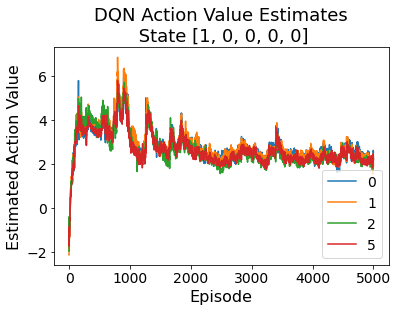

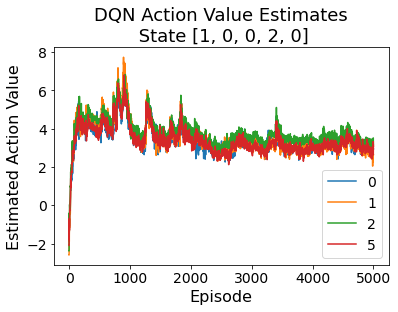

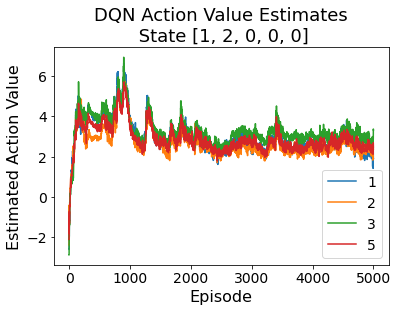

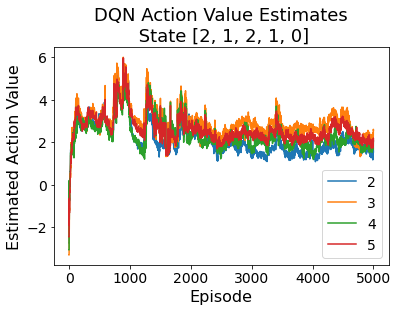

In [56]:
selected_states = [[1, 0, 0, 0, 0], [1, 0, 0, 2, 0], [1, 2, 0, 0, 0], [2, 1, 2, 1, 0]]
selected_states = [torch.tensor([state], device=device, dtype=torch.float) for state in selected_states]

plt.rcParams['font.size'] = 14
for i, s in enumerate(states):
    if (s == selected_states[0]).all() or (s == selected_states[1]).all() or (s == selected_states[2]).all() or (s == selected_states[3]).all():
        plt.figure(i)
        for a, values in Q_plot[s].items():
            plt.plot(values)
        plt.title('DQN Action Value Estimates\n State %s' % str([int(i) for i in s.squeeze().tolist()]), fontsize=18)
        plt.ylabel('Estimated Action Value', fontsize=16)
        plt.xlabel('Episode', fontsize=16)
        plt.legend(Q_plot[s].keys())